### HW 1: Training a linear classifier

아래 코드는 다음 항목을 구현한다.
1. Data 생성+처리: Toy DB 생성, 전처리, training/test 분할
2. Linear classifier 모델 정의 및 관련 연산
3. Gradient descent 알고리즘 및 Linear classifier 모델의 parameter에 대한 gradient 연산
4. 학습된 linear classifier 모델 parameter를 적용하여 test data의 classification 결과 도출

In [1]:
# package 불러오기
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# utility functions

# function: make labels one-hot vectors
# labels : 인코딩을 하려는 레이블이 들어 있는 numpy배열
# num_cls : 레이블의 총 클래스 수를 나타내는 정수
# num_data : 데이터 포인터 수
# np.arange(num_data)는 0부터 num_data-1까지의 정수 배열을 생성. 이 배열은 행 인덱스를 나타냄.
#labels[:]는 labels 배열의 모든 원소를 선택. 이것은 각 데이터 포인트에 해당하는 레이블을 나타냄.

def make_labels_onehot(labels, num_cls): #one hot vector를만
    num_data = labels.shape[0] # labels 배열의 첫 번째 차원의 크기를 num_data 변수에 저장합니다. 이것은 데이터 포인트의 수를 나타냅니다.
    labels_1hot = np.zeros((num_data,num_cls)) #모든 요소가 0인 2D NumPy 배열을 생성. 이 배열은 one-hot 인코딩된 레이블을 저장하기 위한 공간입니다. 이 배열의 크기는 (num_data, num_cls)입니다.
    labels_1hot[np.arange(num_data),labels[:]] = 1 #one-hot 인코딩을 수행하는 부분 abels_1hot 배열의 해당하는 행(데이터 포인트)과 열(클래스)에 1을 할당합니다
    return labels_1hot #배열은 one-hot 인코딩된 레이블을 포함하고, 이 배열이 반환됨

# function: visualize sample images
#이미지 배치를 시각화하는 데 사용됨
def VisualizeBatchData(batch_data, batch_sz):
    f, axarr = plt.subplots(batch_sz)
    ddim_sq = int(np.sqrt(batch_data[0].shape[0]))
    print(W_arr[0].shape[0])
    for i in range(batch_sz):
        axarr[i].imshow(batch_data[i][:].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()

#function: visualize linear classifier weight matrix for gradient descent
#weight를 시각화하는데 사용됨
def VisualizeWeights(W_arr, num_iter, num_cls):
    f, axarr = plt.subplots(num_iter,num_cls)
    ddim_sq = int(np.sqrt(W_arr[0].shape[0]))
    print(W_arr[0].shape[0])
    for i in range(num_iter):
        for j in range(num_cls):
            axarr[i,j].imshow(W_arr[i][:,j].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()

##### 문제 1: Toy dataset 생성

다음 코드는 128x128 크기의 영상을 좌우 반반씩 흑/백 밝기를 갖는 두 종류의 영상 DB를 생성한다.
코드를 먼저 상세히 읽어보고 각 부분의 의미를 이해하자.
코드를 완성하도록 표기된 부분은 직접 코딩을 수행하여 코드가 잘 동작하도록 하여라.

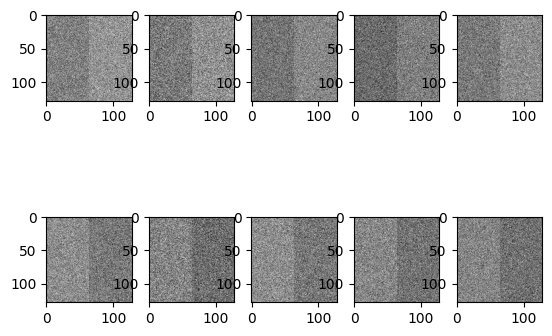

In [3]:
# set toy dataset image configuration 이미지 설정
img_sz = 128 #이미지크기
num_img_per_cls = 100 # 클래스 당 100개의 이미지 존재
num_cls = 2 #데이터 셋에 2개의 클래스 존재
num_imgs = num_img_per_cls*num_cls #이미지의 총 개 수
db_imgs = np.zeros((num_imgs,img_sz,img_sz)) # 이미지를 저장할 numpy 배열

mid_idx = int(img_sz/num_cls) # 클래스 분리를 위한 이미지의 중간 인덱스 계산
db_imgs[:num_img_per_cls,:,mid_idx:] = 1 # class 0: black/white - # 클래스 0을 위한 흑/백 밝기를 갖는 영상 생성
db_imgs[num_img_per_cls:,:,:mid_idx] = 1 # class 1: white/black - # 클래스 1을 위한 백/흑 밝기를 갖는 영상 생성

# add noise with normal distribution
# 정규 분포를 따르는 노이즈 추가
#표준 편차가 1.5인 노이즈를 추가,더 큰 표준 편차는 노이즈가 더 크게 퍼지게 만듬
#이미지 데이터에 num_cls * num_img_per_cls개의 이미지에 각각 img_sz x img_sz 크기의 난수 노이즈 배열을 생성하고 더함
#이미지에 노이즈를 부여하여 이미지의 밝기나 텍스처를 무작위로 변화시키는 효과를 만듭니다.
#결과적으로, 각 이미지에 noise_w로 조절된 정규 분포의 노이즈가 추가되어 이미지 데이터가 더 다양해짐

noise_w = 1.5
db_imgs = db_imgs + noise_w*np.random.randn(num_cls*num_img_per_cls,img_sz,img_sz)


# 샘플 이미지를 시각화
f, axarr = plt.subplots(2,5) # 2x5 그리드의 서브플롯 생성
for i in range(5):
    axarr[0,i].imshow(db_imgs[i,:,:],cmap='gray') # 첫 번째 행에는 클래스 0의 이미지 표시
    axarr[1,i].imshow(db_imgs[num_img_per_cls+i,:,:],cmap='gray') # 두 번째 행에는 클래스 1의 이미지 표시
plt.show()

# pre-process sample images ,샘플 이미지 전처리
# flatten each image to 1D vector(각 이미지를 1차원 벡터로 평탄화) - # 총영상개수x128x128 영상 배열을 총영상개수x128^2 배열로 규격 변경
db_data = db_imgs.reshape(num_imgs, -1)
# subtract mean( 평균값 빼기)
data_mean = np.mean(db_data)
db_data = db_data - data_mean
db_labels = np.zeros((num_cls*num_img_per_cls),dtype='int8') # 레이블 배열 생성
db_labels[:num_img_per_cls] = 0 # 클래스 0에 해당하는 이미지에는 레이블 0 할당
db_labels[num_img_per_cls:2*num_img_per_cls] = 1  # 클래스 1에 해당하는 이미지에는 레이블 1 할당


##### 문제2: Toy dataset - training/test 분할

다음 코드에서는 이전 문제에서 생성한 영상 DB를 임의로 학습용 training 데이터와 실험용 test 데이터로 분할한다.
코드를 먼저 상세히 읽어보고 각 부분의 의미를 이해하자.
코드를 완성하도록 표기된 부분은 직접 코딩을 수행하여 코드가 잘 동작하도록 하여라.

In [4]:
idxs = np.arange(num_img_per_cls) # array of sorted index numbers
np.random.shuffle(idxs) # random shuffle
tr_ratio = 0.2 #훈련데이터와 테스터데이터 비율 정하기

num_tr_data = int(num_img_per_cls*tr_ratio)
tr_data = np.zeros((num_tr_data*num_cls,img_sz*img_sz))
tr_data[:num_tr_data,:] = db_data[idxs[:num_tr_data],:]
tr_data[num_tr_data:2*num_tr_data,:] = db_data[num_img_per_cls+idxs[:num_tr_data],:]


tr_labels = np.zeros((num_tr_data*num_cls),dtype='int8')
tr_labels[:num_tr_data] = 0  #첫 번째 클래스에 대한 레이블을 0으로 설정
tr_labels[num_tr_data: 2*num_tr_data] = 1  #두 번째 클래스에 대한 레이블을 1로 설정



num_te_data = num_img_per_cls-num_tr_data
print(num_te_data)
te_data = np.zeros((num_te_data*num_cls,img_sz*img_sz))
te_data[:num_te_data, :] = db_data[idxs[num_tr_data:num_img_per_cls], :] # 클래스 0의 테스트 데이터 할당
te_data[num_te_data:2*num_te_data, :] = db_data[num_img_per_cls + idxs[num_tr_data:num_img_per_cls], :]# 클래스 1의 테스트 데이터 할당


te_labels = np.zeros((num_te_data*num_cls),dtype='int8')
te_labels[:num_te_data] = db_labels[idxs[num_tr_data:num_img_per_cls]]
te_labels[num_te_data:2*num_te_data] = db_labels[num_img_per_cls+idxs[num_tr_data:num_img_per_cls]]

print(tr_data.shape)

80
(40, 16384)


##### 문제3: Linear classifier 모델의 local gradient 연산 정의

다음 코드는 linear classifier의 객체를 정의하는 class의 코드이다.
코드를 먼저 상세히 읽어보고 각 부분의 의미를 이해하자.
코드를 완성하도록 표기된 부분은 직접 코딩을 수행하여 코드가 잘 동작하도록 하여라.

In [5]:
class LinearClassifier:
    def __init__(self, data_dim, num_cls):
        self.data_dim = data_dim
        self.num_cls = num_cls
        # data_dim <- D in slides, num_cls <- M in slides
        self.W = 0.001 * np.random.randn(data_dim, num_cls)
        self.b = np.random.randint(num_cls)
        self.scores = np.zeros(num_cls)
        self.data = 0
        self.num_data = 0
    def forward(self, data):
        # data dimension is N x D
        self.data = data  #입력 데이터를 클래스 내부에 저장
        self.scores = np.dot(data, self.W) + self.b #연산 수행 후 score에 저
        return self.scores
    def backward(self, upstream_grad):
        # upstream_grad dimensions should be N x M
        # W dimension is D x M
        grad_W = np.dot(self.data.T, upstream_grad)  #- W의 local gradient 계산
        # W dimension is 1 x M
        grad_b = np.sum(upstream_grad, axis=0)  # 코딩 수행 - b의 local gradient 계산
        grad = {'W':grad_W,'b':grad_b}
        return grad
    def grad_descent(self, grad, lr):
        grad_W = grad['W']
        grad_b = grad['b']
        self.W = self.W - lr*grad_W
        self.b = self.b - lr*grad_b
    def visualize_weights(self):
        f, axarr = plt.subplots(self.num_cls)
        ddim_sq = int(np.sqrt(self.W.shape[0]))
        for j in range(self.num_cls):
            axarr[j].imshow(self.W[:,j].reshape(ddim_sq,ddim_sq),cmap='gray')
        plt.show()


##### 문제4: Softmax loss 함수의 local gradient 연산 정의

다음 코드는 Softmax 함수 기반의 cross-entropy loss 함수와 이를 기준으로 모델을 학습하는데 필요한 gradient를 계산하는 과정을 포함한다.
코드를 먼저 상세히 읽어보고 각 부분의 의미를 이해하자.
코드를 완성하도록 표기된 부분은 직접 코딩을 수행하여 코드가 잘 동작하도록 하여라.
[아울러 SoftMaxLoss 클래스의 compute_grad 함수의 경우 아래 구현된 코드를 바탕으로 softmax 함수의 gradient의 수식 등을 포함한 이론을 정리하여 제시하라. 제공된 결과보고서 파일에 개별 챕터로 정리하여 제출한다.]

In [6]:
class SoftMaxLoss:
    def __init__(self, model, num_cls):
        # set model object
        self.model = model
        self.model_scores = 0
        self.softmax_probs = 0
        self.loss = 0
        self.data = 0
        self.probs = 0
        self.labels = 0
        self.num_cls = num_cls
    def compute_probs(self, data): #주어진 data를 사용하여 class에 속할 확률을 계산
        scores = self.model.forward(data)
        self.model_scores = scores
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True)) #softmax 함수 계산
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) #softmax 함수 계산
        return self.probs
    def compute_loss(self, data, labels): #loss 계산
        self.data = data
        num_data = data.shape[0]
        self.compute_probs(data)
        self.labels = labels
        labels = np.array(labels) # cross-entropy loss 함수값 계산
        correct_class_probs = self.probs[np.arange(num_data), labels]#cross-entropy loss 함수값 계산
        neg_log_probs = -np.log(correct_class_probs)  #cross-entropy loss 함수값 계산
        self.loss = np.sum(neg_log_probs) / num_data  #cross-entropy loss 함수값 계산
        return self.loss
    def compute_grad(self):
        # score dimensions should be N x M
        z = self.probs
        # grad_z dimensions should also be N x M
        grad_z = z - make_labels_onehot(self.labels,self.num_cls)
        return self.model.backward(grad_z)


##### 문제5: Gradient descent 알고리즘 구현

다음 코드는 gradient descent 알고리즘으로 학습 데이터에 대해 linear classifier를 학습하는 코드이다.
코드를 먼저 상세히 읽어보고 각 부분의 의미를 이해하자.
코드를 완성하도록 표기된 부분은 직접 코딩을 수행하여 코드가 잘 동작하도록 하여라.

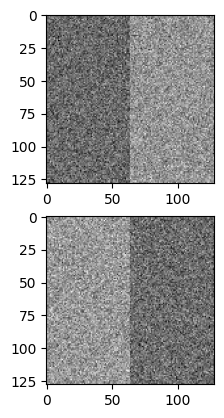

In [7]:
def get_mini_batch(batch_sz, db_data, db_labels, num_data):
    indices = np.random.choice(num_data, batch_sz, replace=False)
    batch_data = db_data[indices] #mini batch data 추출
    batch_labels = db_labels[indices] #mini batch label 표본 추출
    # VisualizeBatchData(batch_data,batch_sz)
    return batch_data, batch_labels

def train_linear_classifier(db_data, db_labels, num_cls, lr, batch_sz, num_iter):
    # define & initialize linear classifier
    num_data = db_data.shape[0]
    data_dim = db_data.shape[1]
    model = LinearClassifier(data_dim, num_cls)
    # define loss function
    loss_fn = SoftMaxLoss(model,num_cls)
    # iterative stochastic gradient descent
    for i in range(num_iter):
        # sample data mini-batch
        batch_data, batch_labels = get_mini_batch(batch_sz, db_data, db_labels, num_data)
        # compute loss value
        loss = loss_fn.compute_loss(batch_data, batch_labels)
        # print('loss=',loss)
        # compute gradient (backpropagation)
        grad = loss_fn.compute_grad()
        # update model parameters using gradient
        model.grad_descent(grad, lr)
    model.visualize_weights()
    return model

lr = 0.0005
batch_sz = 8
num_iter = 100
model = train_linear_classifier(tr_data, tr_labels, num_cls, 0.0005, 8, 100)


##### 문제6: 학습된 모델을 이용한 test data classification

다음 코드에서는 학습된 linear classifier를 이용하여 테스트 데이터의 판별 결과를 도출한다.
코드를 먼저 상세히 읽어보고 각 부분의 의미를 이해하자.
코드를 완성하도록 표기된 부분은 직접 코딩을 수행하여 코드가 잘 동작하도록 하여라.

In [8]:
te_scores = model.forward(te_data) # model에 test data를 입력하여 예측 score 계산
te_predictions = np.argmax(te_scores, axis=1) #예측값 계산,index를 반환하는것
correct_predictions = np.sum(te_predictions == te_labels)  # 정확하게 예측한 개수 계산
Acc = correct_predictions / len(te_labels)  # 정확도 계산
print('Classification accuracy=', Acc) #정확도 출력

Classification accuracy= 1.0


##### 문제7: 더 어려운 3 class toy 데이터 생성하여 위 과정 반복 후 결과 정리

본 문제에서는 아래 전체 과정 중 1번 항목을 자체적으로 구현하고, 이후의 부분은 위의 코드를 활용하여 결과를 도출하는 것을 목표로 한다.
[1]. Data 생성+처리: Toy DB 생성, 전처리, training/test 분할 <- 이 부분에서 3가지 클래스로 구성되는 간단한 영상 DB을 생성하는 코딩 수행
2. Linear classifier 모델 정의 및 관련 연산
3. Gradient descent 알고리즘 및 Linear classifier 모델의 parameter에 대한 gradient 연산
4. 학습된 linear classifier 모델 parameter를 적용하여 test data의 classification 결과 도출

[도출된 결과는 제공된 결과보고서 파일에 챕터를 만들어서 정리하여 제출한다.]

**[1]DATA 생성 + 처리 : Toy DB, 전처리, training/test 분할**

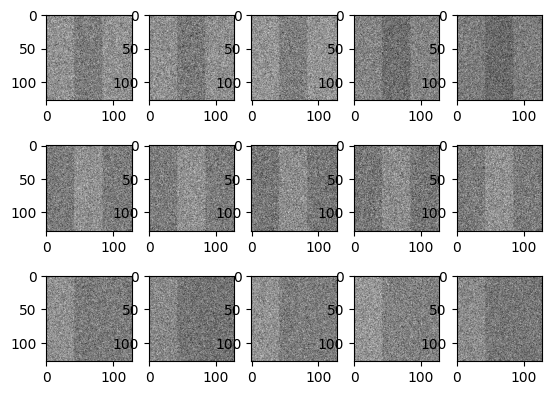

80
(60, 16384)


In [11]:
# set toy dataset image configuration 이미지 설정
img_sz = 128 #이미지크기
num_img_per_cls = 100 # 클래스 당 100개의 이미지 존재
num_cls = 3
num_imgs = num_img_per_cls*num_cls
db_imgs = np.zeros((num_imgs,img_sz,img_sz))

section_width = img_sz // 3
# 클래스 0: 백/흑/백 이미지 생성
db_imgs[:num_img_per_cls, :, :section_width] = 1  # 왼쪽을 1로 설정
db_imgs[:num_img_per_cls, :, section_width:2*section_width] = 0  # 가운데를 0으로 설정
db_imgs[:num_img_per_cls, :, 2*section_width:] = 1  # 오른쪽을 1로 설정

# 클래스 1: 흑/백/흑 이미지 생성
db_imgs[num_img_per_cls:2*num_img_per_cls, :, :section_width] = 0  # 왼쪽을 0으로 설정
db_imgs[num_img_per_cls:2*num_img_per_cls, :, section_width:2*section_width] = 1  # 가운데를 1로 설정
db_imgs[num_img_per_cls:2*num_img_per_cls, :, 2*section_width:] = 0  # 오른쪽을 0으로 설정

# 클래스 2: 백/흑/흑 이미지 생성
db_imgs[2*num_img_per_cls:, :, :section_width] = 1  # 왼쪽을 1로 설정
db_imgs[2*num_img_per_cls:, :, section_width:2*section_width] = 0  # 가운데를 0으로 설정
db_imgs[2*num_img_per_cls:, :, 2*section_width:] = 0  # 오른쪽을 0으로 설정

# add noise with normal distribution
noise_w = 1.5
db_imgs = db_imgs + noise_w*np.random.randn(num_cls*num_img_per_cls,img_sz,img_sz)


# 샘플 이미지를 시각화
f, axarr = plt.subplots(3,5) # 2x5 그리드의 서브플롯 생성
for i in range(5):
    axarr[0,i].imshow(db_imgs[i,:,:],cmap='gray') # 첫 번째 행에는 클래스 0의 이미지 표시
    axarr[1,i].imshow(db_imgs[num_img_per_cls+i,:,:],cmap='gray') # 두 번째 행에는 클래스 1의 이미지 표시
    axarr[2,i].imshow(db_imgs[2*num_img_per_cls + i,:,:], cmap='gray') # 세 번째 행에는 클래스 2의 이미지 표시
plt.show()

# pre-process sample images ,샘플 이미지 전처리
# flatten each image to 1D vector(각 이미지를 1차원 벡터로 평탄화) - # 총영상개수x128x128 영상 배열을 총영상개수x128^2 배열로 규격 변경
db_data = db_imgs.reshape(num_imgs, -1) # **코딩 수행** 위에 설명수행

# subtract mean( 평균값 빼기)
data_mean = np.mean(db_data)
db_data = db_data - data_mean
# 데이터셋에 레이블 할당
db_labels = np.zeros((num_cls*num_img_per_cls),dtype='int8') # 레이블 배열 생성
db_labels[:num_img_per_cls] = 0 # 클래스 0에 해당하는 이미지에는 레이블 0 할당
db_labels[num_img_per_cls:2*num_img_per_cls] = 1  # 클래스 1에 해당하는 이미지에는 레이블 1 할당
db_labels[2 * num_img_per_cls:] = 2  # 클래스 2에 해당하는 이미지에는 레이블 2 할당




idxs = np.arange(num_img_per_cls) # array of sorted index numbers
np.random.shuffle(idxs) # random shuffle
tr_ratio = 0.2

num_tr_data = int(num_img_per_cls*tr_ratio)
tr_data = np.zeros((num_tr_data*num_cls,img_sz*img_sz))
tr_data[:num_tr_data, :] = db_data[idxs[:num_tr_data], :]
tr_data[num_tr_data:2*num_tr_data, :] = db_data[num_img_per_cls + idxs[:num_tr_data], :]
tr_data[2*num_tr_data:3*num_tr_data, :] = db_data[2 * num_img_per_cls + idxs[:num_tr_data], :]


tr_labels = np.zeros((num_tr_data*num_cls),dtype='int8')
tr_labels[:num_tr_data] = 0
tr_labels[num_tr_data:2 * num_tr_data] = 1
tr_labels[2*num_tr_data:3*num_tr_data] = 2


num_te_data = num_img_per_cls-num_tr_data
print(num_te_data)
te_data = np.zeros((num_te_data*num_cls, img_sz*img_sz))
te_data[:num_te_data, :] = db_data[idxs[num_tr_data:num_img_per_cls], :]  # 클래스 0의 테스트 데이터 할당
te_data[num_te_data:2*num_te_data, :] = db_data[num_img_per_cls + idxs[num_tr_data:num_img_per_cls], :]  # 클래스 1의 테스트 데이터 할당
te_data[num_te_data*2:, :] = db_data[2*num_img_per_cls + idxs[num_tr_data:num_img_per_cls], :]  # 클래스 2의 테스트 데이터 할당

te_labels = np.zeros((num_te_data*num_cls),dtype='int8')
te_labels[:num_te_data] = db_labels[idxs[num_tr_data:num_img_per_cls]]
te_labels[num_te_data:2*num_te_data] = db_labels[num_img_per_cls+idxs[num_tr_data:num_img_per_cls]]
te_labels[2 * num_te_data:3 * num_te_data] = db_labels[2 * num_img_per_cls + idxs[num_tr_data:num_img_per_cls]]

print(tr_data.shape)

**[2]Linear classifier 모델 정의 및 관련 연산**

In [12]:
class LinearClassifier:
    def __init__(self, data_dim, num_cls):
        self.data_dim = data_dim
        self.num_cls = num_cls
        # data_dim <- D in slides, num_cls <- M in slides
        self.W = 0.001 * np.random.randn(data_dim, num_cls)
        self.b = np.random.randint(num_cls)
        self.scores = np.zeros(num_cls)
        self.data = 0
        self.num_data = 0
    def forward(self, data):
        # data dimension is N x D
        self.data = data  #입력 데이터를 클래스 내부에 저장
        self.scores = np.dot(data, self.W) + self.b #연산 수행 후 score에 저
        return self.scores
    def backward(self, upstream_grad):
        # upstream_grad dimensions should be N x M
        # W dimension is D x M
        grad_W = np.dot(self.data.T, upstream_grad)  #- W의 local gradient 계산
        # W dimension is 1 x M
        grad_b = np.sum(upstream_grad, axis=0)  # 코딩 수행 - b의 local gradient 계산
        grad = {'W':grad_W,'b':grad_b}
        return grad
    def grad_descent(self, grad, lr):
        grad_W = grad['W']
        grad_b = grad['b']
        self.W = self.W - lr*grad_W
        self.b = self.b - lr*grad_b
    def visualize_weights(self):
        f, axarr = plt.subplots(self.num_cls)
        ddim_sq = int(np.sqrt(self.W.shape[0]))
        for j in range(self.num_cls):
            axarr[j].imshow(self.W[:,j].reshape(ddim_sq,ddim_sq),cmap='gray')
        plt.show()


**[3]Gradient descent 알고리즘 및 Linear classifier 모델의 parameter에 대한 gradient 연산**

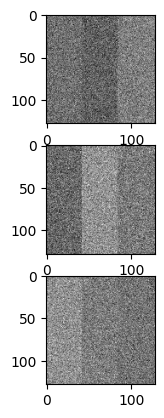

In [15]:
class SoftMaxLoss:
    def __init__(self, model, num_cls):
        # set model object
        self.model = model
        self.model_scores = 0
        self.softmax_probs = 0
        self.loss = 0
        self.data = 0
        self.probs = 0
        self.labels = 0
        self.num_cls = num_cls
    def compute_probs(self, data): #주어진 data를 사용하여 class에 속할 확률을 계산
        scores = self.model.forward(data)
        self.model_scores = scores
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True)) #softmax 함수 계산
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) #softmax 함수 계산
        return self.probs
    def compute_loss(self, data, labels): #loss 계산
        self.data = data
        num_data = data.shape[0]
        self.compute_probs(data)
        self.labels = labels
        labels = np.array(labels) # cross-entropy loss 함수값 계산
        correct_class_probs = self.probs[np.arange(num_data), labels]#cross-entropy loss 함수값 계산
        neg_log_probs = -np.log(correct_class_probs)  #cross-entropy loss 함수값 계산
        self.loss = np.sum(neg_log_probs) / num_data  #cross-entropy loss 함수값 계산
        return self.loss
    def compute_grad(self):
        # score dimensions should be N x M
        z = self.probs
        # grad_z dimensions should also be N x M
        grad_z = z - make_labels_onehot(self.labels,self.num_cls)
        return self.model.backward(grad_z)


def get_mini_batch(batch_sz, db_data, db_labels, num_data):
    indices = np.random.choice(num_data, batch_sz, replace=False)
    batch_data = db_data[indices] #mini batch data 추출
    batch_labels = db_labels[indices] #mini batch label 표본 추출
    # VisualizeBatchData(batch_data,batch_sz)
    return batch_data, batch_labels

def train_linear_classifier(db_data, db_labels, num_cls, lr, batch_sz, num_iter):
    # define & initialize linear classifier
    num_data = db_data.shape[0]
    data_dim = db_data.shape[1]
    model = LinearClassifier(data_dim, num_cls)
    # define loss function
    loss_fn = SoftMaxLoss(model,num_cls)
    # iterative stochastic gradient descent
    for i in range(num_iter):
        # sample data mini-batch
        batch_data, batch_labels = get_mini_batch(batch_sz, db_data, db_labels, num_data)
        # compute loss value
        loss = loss_fn.compute_loss(batch_data, batch_labels)
        # print('loss=',loss)
        # compute gradient (backpropagation)
        grad = loss_fn.compute_grad()
        # update model parameters using gradient
        model.grad_descent(grad, lr)
    model.visualize_weights()
    return model

lr = 0.0005
batch_sz = 8
num_iter = 100
model = train_linear_classifier(tr_data, tr_labels, num_cls, 0.0005, 8, 100)

**학습된 linear classifier 모델 parameter를 적용하여 test data의 classification 결과 도출**

In [18]:
te_scores = model.forward(te_data) # model에 test data를 입력하여 예측 score 계산
te_predictions = np.argmax(te_scores, axis=1) #예측값 계산,index를 반환하는것
correct_predictions = np.sum(te_predictions == te_labels)  # 정확하게 예측한 개수 계산
Acc = correct_predictions / len(te_labels)  # 정확도 계산
print('Classification accuracy=', Acc) #정확도 출력

Classification accuracy= 1.0
